In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import config

In [3]:
data_file = config.DATA_DIR / 'BOB_daily_data.csv'
df = pd.read_csv(data_file, parse_dates=['timestamp'], index_col='timestamp')
df = df[df.index > '2024-05-05']

<Axes: xlabel='timestamp'>

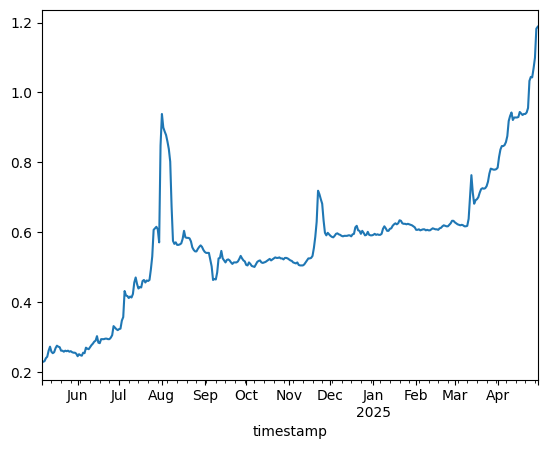

In [4]:
premium = (df['USDT_BOB_Binance_sell_vwap'] / 6.97) - 1
premium.plot.line()

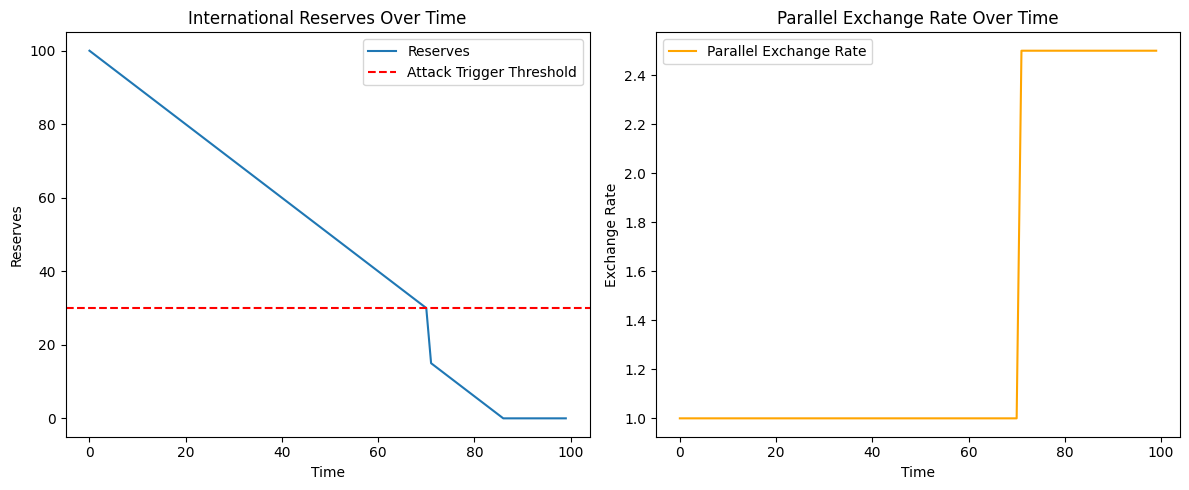

In [5]:
# Parameters
T = 100  # total time steps
initial_reserves = 100  # starting level of reserves
reserve_depletion_rate = 1.0  # rate at which reserves are used per period
attack_trigger_threshold = 30  # critical level triggering speculative attack
speculative_attack_intensity = 15  # how much reserves fall during the attack
initial_parallel_rate = 1.0
parallel_rate_jump = 2.5  # how much the parallel rate jumps after the attack

# Initialize arrays
reserves = np.zeros(T)
parallel_rate = np.ones(T) * initial_parallel_rate
speculative_attack_occurred = False

reserves[0] = initial_reserves

for t in range(1, T):
    if not speculative_attack_occurred and reserves[t - 1] <= attack_trigger_threshold:
        # Simulate speculative attack
        reserves[t] = max(0, reserves[t - 1] - speculative_attack_intensity)
        speculative_attack_occurred = True
        parallel_rate[t] = parallel_rate_jump
    else:
        reserves[t] = max(0, reserves[t - 1] - reserve_depletion_rate)
        parallel_rate[t] = parallel_rate[t - 1] if not speculative_attack_occurred else parallel_rate_jump

# Create a DataFrame to display
df = pd.DataFrame({
    'Time': np.arange(T),
    'Reserves': reserves,
    'Parallel Exchange Rate': parallel_rate
})

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(reserves, label='Reserves')
plt.axhline(y=attack_trigger_threshold, color='r', linestyle='--', label='Attack Trigger Threshold')
plt.title('International Reserves Over Time')
plt.xlabel('Time')
plt.ylabel('Reserves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(parallel_rate, label='Parallel Exchange Rate', color='orange')
plt.title('Parallel Exchange Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()

plt.tight_layout()
plt.show()


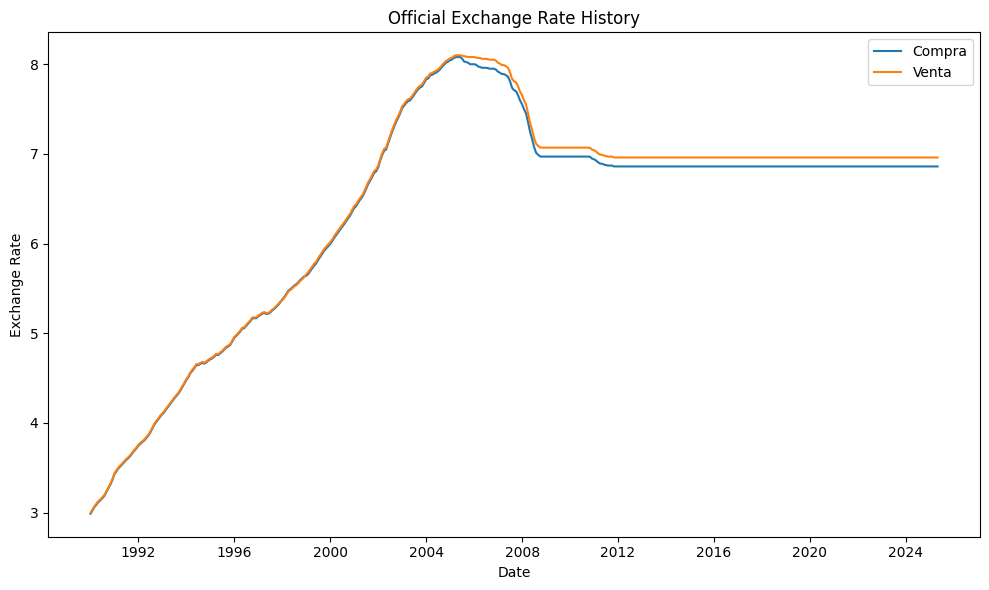

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import config

file = config.DATA_DIR / 'various_thesis_data/official_exchange_rate_history.csv'
# Load data
df = pd.read_csv(file)

# Clean and parse year
df['Year'] = df['AÑO'].str.replace(',', '').astype(int)

# Map Spanish month abbreviations to numbers
month_map = {
    'ENE': 1, 'FEB': 2, 'MAR': 3, 'ABR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AGO': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DIC': 12
}
df['Month'] = df['MES'].map(month_map)

# Create a datetime column (first day of each month)
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))

# Sort by date
df = df.sort_values('Date')

# Plot 'COMPRA' and 'VENTA'
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['COMPRA'], label='Compra')
plt.plot(df['Date'], df['VENTA'], label='Venta')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Official Exchange Rate History')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
import yfinance as yf
import pandas as pd
from datetime import datetime


def get_gold_monthly_avg(ticker: str = "GC=F") -> pd.DataFrame:
    """
    Downloads daily gold-futures prices since January 1 of the previous year
    and returns a DataFrame with the average closing price for each month.

    Parameters
    ----------
    ticker : str
        The yfinance ticker symbol for gold futures (default "GC=F").

    Returns
    -------
    pd.DataFrame
        A DataFrame with two columns:
        - 'Date': Timestamp for the last day of each month.
        - 'MonthlyAvg': The average of the daily closing prices in that month.
    """
    # Determine the start date: January 1 of the previous year
    now = datetime.now()
    start_of_prev_year = datetime(year=2004, month=1, day=1)

    # Download daily data from yfinance
    df = yf.download(ticker, start=start_of_prev_year.strftime("%Y-%m-%d"), progress=False)

    # Ensure the index is a datetime index
    df.index = pd.to_datetime(df.index)

    # Resample to month-end frequency and compute the mean of the 'Close' column
    monthly_avg = (
        df['Close']
        .resample('M')  # group by each calendar month, using month-end labels
        .mean()  # average of daily closes in each group
        .reset_index()  # turn the DatetimeIndex back into a column
        .rename(columns={'Close': 'MonthlyAvg'})
    )

    return monthly_avg


df_gold = get_gold_monthly_avg()
df_gold

YF.download() has changed argument auto_adjust default to True


/var/folders/k4/tzrrs0b10b9g7npgkqvwbyr00000gn/T/ipykernel_61523/1021456211.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')  # group by each calendar month, using month-end labels


Ticker,Date,GC=F
0,2004-01-31,414.726317
1,2004-02-29,403.952630
2,2004-03-31,407.469565
3,2004-04-30,403.957142
4,2004-05-31,383.769995
...,...,...
252,2025-01-31,2722.947626
253,2025-02-28,2897.115800
254,2025-03-31,2986.409528
255,2025-04-30,3211.152367


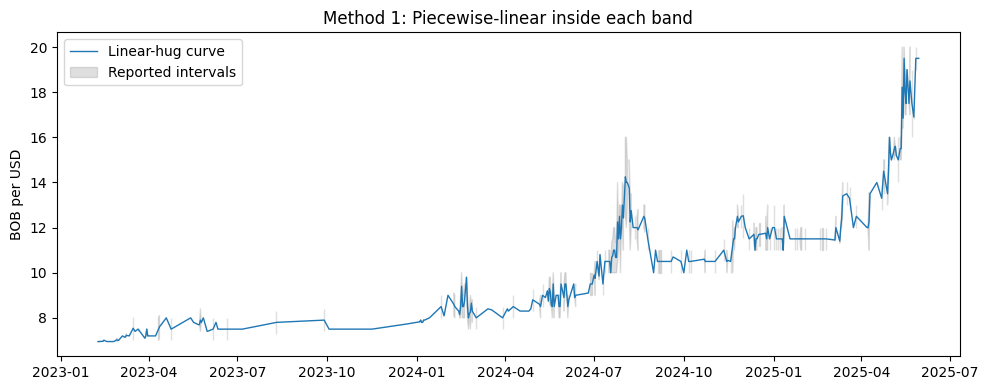

In [17]:
from utils.mongo_controller import mongo_controller

df = mongo_controller.query_data(_mode='all', collection='Daily_Averages')

df = df[['timestamp', 'USD_BOB_Parallel']]
df['USD_BOB_Parallel'] = df['USD_BOB_Parallel'].apply(
    lambda x: x['quote_interval'] if isinstance(x, dict) else [None, None])
df['lower_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[0])
df['upper_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[1])
df.drop(columns=['USD_BOB_Parallel'], inplace=True)
df = df[df['timestamp'] > '2023-02-01']  # filter to recent data

import pandas as pd
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────────────────
# 1) ASSUME you already have `df` with columns:
#      - timestamp (datetime64)
#      - lower_bound (float or NaN)
#      - upper_bound (float or NaN)
# ────────────────────────────────────────────────────────────────────────────────
df = df.copy().sort_values('timestamp')
df.set_index('timestamp', inplace=True)

# ────────────────────────────────────────────────────────────────────────────────
# 2) CHOOSE ANCHORS INSIDE EACH INTERVAL
#    Here: simple midpoint
# ────────────────────────────────────────────────────────────────────────────────
anchors = df[['lower_bound', 'upper_bound']].mean(axis=1)

# Optional tweak: bias 40% toward the upper edge instead
# width = df['upper_bound'] - df['lower_bound']
# anchors = df['lower_bound'] + 0.4 * width

# ────────────────────────────────────────────────────────────────────────────────
# 3) BUILD A DAILY SERIES AND LINEAR-INTERPOLATE
# ────────────────────────────────────────────────────────────────────────────────
full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
series = anchors.reindex(full_idx)  # put anchors on daily grid (NaN where missing)
curve = series.interpolate(method='linear')  # straight-line bridging

# ────────────────────────────────────────────────────────────────────────────────
# 4) PLOT THE RESULT
# ────────────────────────────────────────────────────────────────────────────────
lo = df['lower_bound'].reindex(full_idx)
hi = df['upper_bound'].reindex(full_idx)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(curve.index, curve.values, label='Linear-hug curve', linewidth=1)
ax.fill_between(full_idx, lo, hi, color='grey', alpha=0.25,
                label='Reported intervals')
ax.set_ylabel('BOB per USD')
ax.set_title('Method 1: Piecewise-linear inside each band')
ax.legend()
plt.tight_layout()
plt.show()


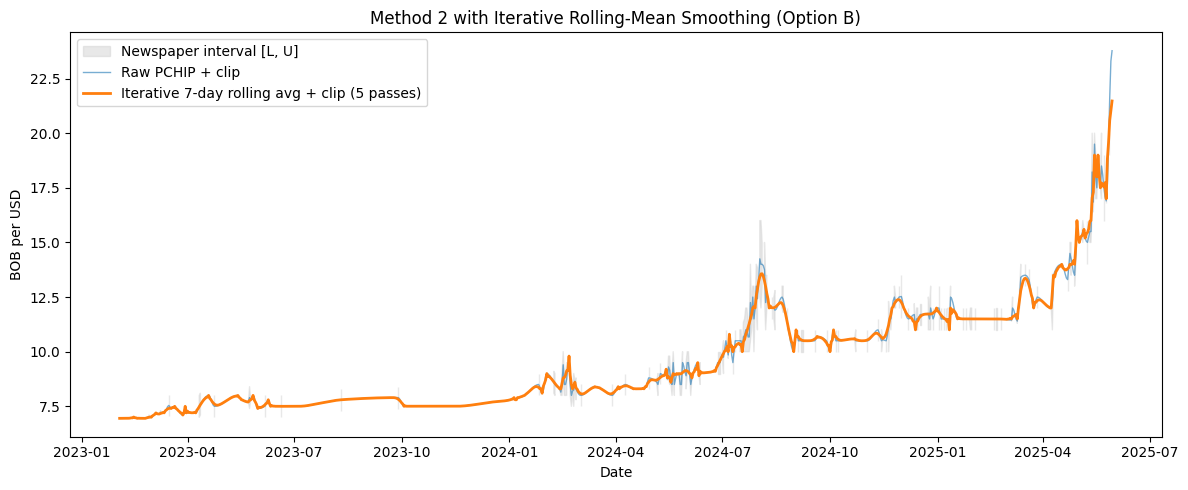

In [9]:
from utils.mongo_controller import mongo_controller

df = mongo_controller.query_data(_mode='all', collection='Daily_Averages')

df = df[['timestamp', 'USD_BOB_Parallel']]
df['USD_BOB_Parallel'] = df['USD_BOB_Parallel'].apply(
    lambda x: x['quote_interval'] if isinstance(x, dict) else [None, None])
df['lower_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[0])
df['upper_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[1])
df.drop(columns=['USD_BOB_Parallel'], inplace=True)
df = df[df['timestamp'] > '2023-02-01']  # filter to recent data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

# ────────────────────────────────────────────────────────────────────────────────
# 1) LOAD & PREPARE YOUR DATAFRAME
#    df must have columns: timestamp, lower_bound, upper_bound
# ────────────────────────────────────────────────────────────────────────────────
df = df.copy().sort_values('timestamp')
df.set_index('timestamp', inplace=True)

# build a daily grid spanning the full range
full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')

# ────────────────────────────────────────────────────────────────────────────────
# 2) METHOD 2: INTERVAL-CONSTRAINED PCHIP + CLIP
# ────────────────────────────────────────────────────────────────────────────────
# 2a) define anchors as mid-points of each interval
anchors = df[['lower_bound', 'upper_bound']].mean(axis=1).dropna()
anchor_dates = anchors.index
anchor_vals = anchors.values

# 2b) convert dates to numeric for PCHIP
anchor_x = anchor_dates.astype(np.int64) / 1e9  # seconds since epoch
grid_x = full_idx.astype(np.int64) / 1e9

# 2c) fit PCHIP through anchors and evaluate on full grid
spline1 = PchipInterpolator(anchor_x, anchor_vals)
curve_raw = pd.Series(spline1(grid_x), index=full_idx)

# 2d) retrieve original [L, U] on the grid and clip
lo = df['lower_bound'].reindex(full_idx)
hi = df['upper_bound'].reindex(full_idx)
curve_clipped = curve_raw.clip(lower=lo, upper=hi)

# ────────────────────────────────────────────────────────────────────────────────
# 3) SMOOTHING PASS B: iterative rolling-mean + clip
# ────────────────────────────────────────────────────────────────────────────────
y = curve_clipped.copy()
for _ in range(3):  # repeat smoothing 5 times
    y = y.rolling(window=5, center=True, min_periods=1).mean()
    y = y.clip(lower=lo, upper=hi)
curve_smoothB = y

# ────────────────────────────────────────────────────────────────────────────────
# 4) PLOT COMPARISON
# ────────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))

# shade the newspaper intervals
ax.fill_between(full_idx, lo, hi,
                color='lightgrey', alpha=0.5,
                label='Newspaper interval [L, U]')

# raw PCHIP+clip
ax.plot(curve_clipped, label='Raw PCHIP + clip', linewidth=1, alpha=0.6)

# iterative rolling-mean + clip
ax.plot(curve_smoothB, label='Iterative 7-day rolling avg + clip (5 passes)', linewidth=2)

ax.set_xlabel('Date')
ax.set_ylabel('BOB per USD')
ax.set_title('Method 2 with Iterative Rolling-Mean Smoothing (Option B)')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


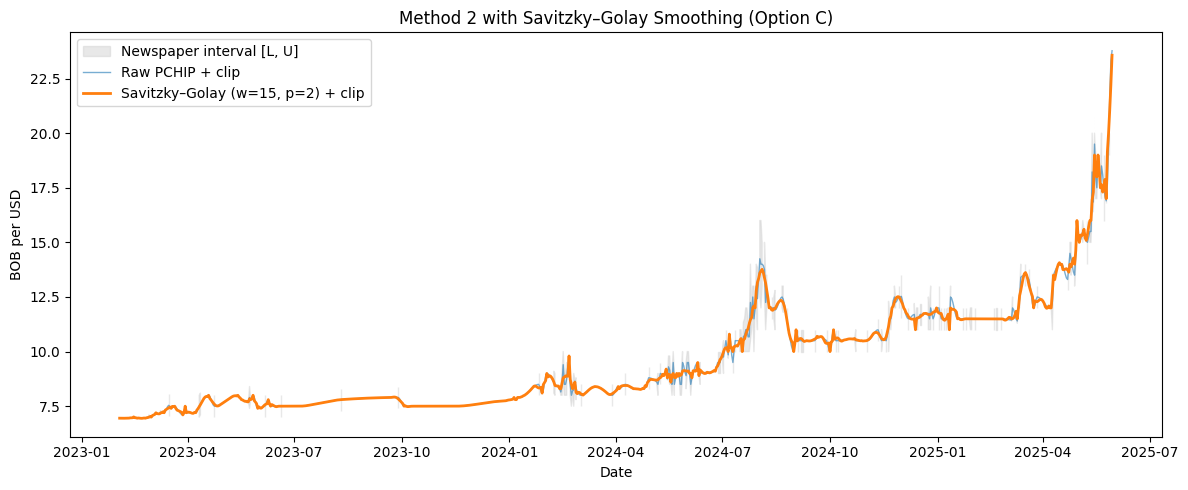

In [10]:
from utils.mongo_controller import mongo_controller

df = mongo_controller.query_data(_mode='all', collection='Daily_Averages')

df = df[['timestamp', 'USD_BOB_Parallel']]
df['USD_BOB_Parallel'] = df['USD_BOB_Parallel'].apply(
    lambda x: x['quote_interval'] if isinstance(x, dict) else [None, None])
df['lower_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[0])
df['upper_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[1])
df.drop(columns=['USD_BOB_Parallel'], inplace=True)
df = df[df['timestamp'] > '2023-02-01']  # filter to recent data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from scipy.signal import savgol_filter

# ────────────────────────────────────────────────────────────────────────────────
# 1) LOAD & PREPARE YOUR DATAFRAME
#    df must have columns: timestamp, lower_bound, upper_bound
# ────────────────────────────────────────────────────────────────────────────────
df = df.copy().sort_values('timestamp')
df.set_index('timestamp', inplace=True)

# build a daily grid spanning the full range
full_idx = pd.date_range(df.index.min(), df.index.max(), freq='D')

# ────────────────────────────────────────────────────────────────────────────────
# 2) METHOD 2: INTERVAL-CONSTRAINED PCHIP + CLIP
# ────────────────────────────────────────────────────────────────────────────────
# 2a) define anchors as mid-points of each interval
anchors = df[['lower_bound', 'upper_bound']].mean(axis=1).dropna()
anchor_dates = anchors.index
anchor_vals = anchors.values

# 2b) convert dates to numeric for PCHIP
anchor_x = anchor_dates.astype(np.int64) / 1e9  # seconds since epoch
grid_x = full_idx.astype(np.int64) / 1e9

# 2c) fit PCHIP through anchors and evaluate on full grid
spline1 = PchipInterpolator(anchor_x, anchor_vals)
curve_raw = pd.Series(spline1(grid_x), index=full_idx)

# 2d) retrieve original [L, U] on the grid and clip
lo = df['lower_bound'].reindex(full_idx)
hi = df['upper_bound'].reindex(full_idx)
curve_clipped = curve_raw.clip(lower=lo, upper=hi)

# ────────────────────────────────────────────────────────────────────────────────
# 3) SMOOTHING PASS C: Savitzky–Golay filter + clip
# ────────────────────────────────────────────────────────────────────────────────
# choose an odd window length (e.g. 15 days) and polynomial order (e.g. 3)
window_length = 15  # must be odd and <= len(curve_clipped)
polyorder = 2

# apply the filter (mode='interp' to handle edges)
filtered = savgol_filter(curve_clipped.values,
                         window_length=window_length,
                         polyorder=polyorder,
                         mode='interp')

curve_smoothC = pd.Series(filtered, index=full_idx).clip(lower=lo, upper=hi)

# ────────────────────────────────────────────────────────────────────────────────
# 4) PLOT COMPARISON
# ────────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))

# shade the newspaper intervals
ax.fill_between(full_idx, lo, hi,
                color='lightgrey', alpha=0.5,
                label='Newspaper interval [L, U]')

# raw PCHIP+clip
ax.plot(curve_clipped, label='Raw PCHIP + clip', linewidth=1, alpha=0.6)

# Savitzky–Golay smoothed + clip
ax.plot(curve_smoothC, label=f'Savitzky–Golay (w={window_length}, p={polyorder}) + clip',
        linewidth=2)

ax.set_xlabel('Date')
ax.set_ylabel('BOB per USD')
ax.set_title('Method 2 with Savitzky–Golay Smoothing (Option C)')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


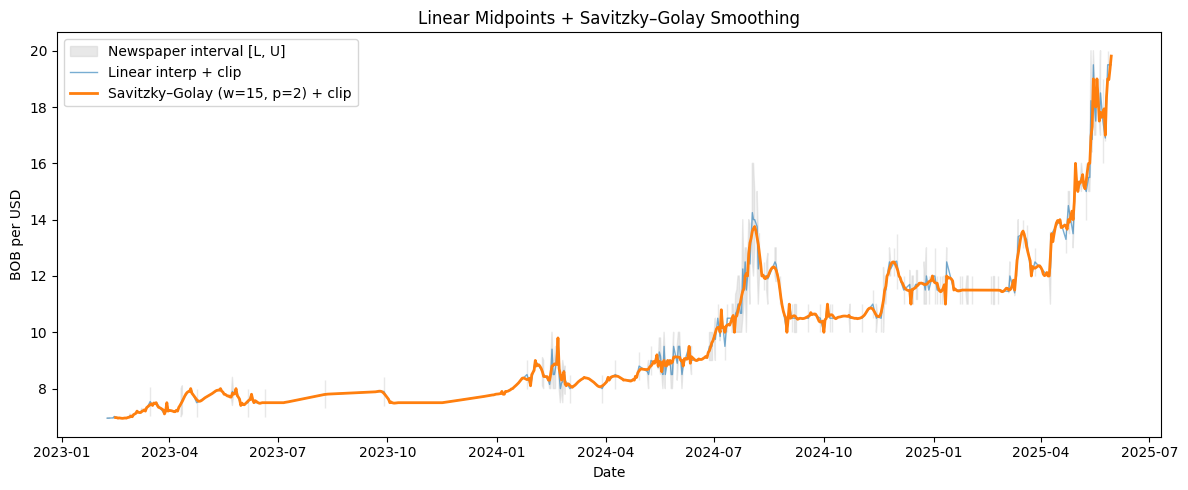

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from utils.mongo_controller import mongo_controller

df = mongo_controller.query_data(_mode='all', collection='Daily_Averages')

df = df[['timestamp', 'USD_BOB_Parallel']]
df['USD_BOB_Parallel'] = df['USD_BOB_Parallel'].apply(
    lambda x: x['quote_interval'] if isinstance(x, dict) else [None, None])
df['lower_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[0])
df['upper_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[1])
df.drop(columns=['USD_BOB_Parallel'], inplace=True)
df = df[df['timestamp'] > '2023-02-01'].copy()
df.sort_values('timestamp')
df.set_index('timestamp', inplace=True)

date_index = pd.date_range(df.index.min(), df.index.max(), freq='D')
# Compute midpoints of intervals as anchors
anchors = df[['lower_bound', 'upper_bound']].mean(axis=1).dropna()
# Align anchors to full daily grid and do linear interpolation
midpoint_series = anchors.reindex(date_index)
curve_linear = midpoint_series.interpolate(method='linear')

# Retrieve original bounds on the grid for clipping
lo = df['lower_bound'].reindex(date_index)
hi = df['upper_bound'].reindex(date_index)

# Clip the linear interpolation to [lower, upper]
curve_clipped_lin = curve_linear.clip(lower=lo, upper=hi)

# Smoothing with Savitzky–Golay filter
window_length = 15  # must be odd
polyorder = 2
filtered = savgol_filter(
    curve_clipped_lin.values,
    window_length=window_length,
    polyorder=polyorder,
    mode='interp'
)
curve_smooth_lin = pd.Series(filtered, index=date_index).clip(lower=lo, upper=hi)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 5))
ax.fill_between(date_index, lo, hi,
                color='lightgrey', alpha=0.5,
                label='Newspaper interval [L, U]')
ax.plot(curve_clipped_lin, label='Linear interp + clip', linewidth=1, alpha=0.6)
ax.plot(curve_smooth_lin,
        label=f'Savitzky–Golay (w={window_length}, p={polyorder}) + clip',
        linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('BOB per USD')
ax.set_title('Linear Midpoints + Savitzky–Golay Smoothing')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


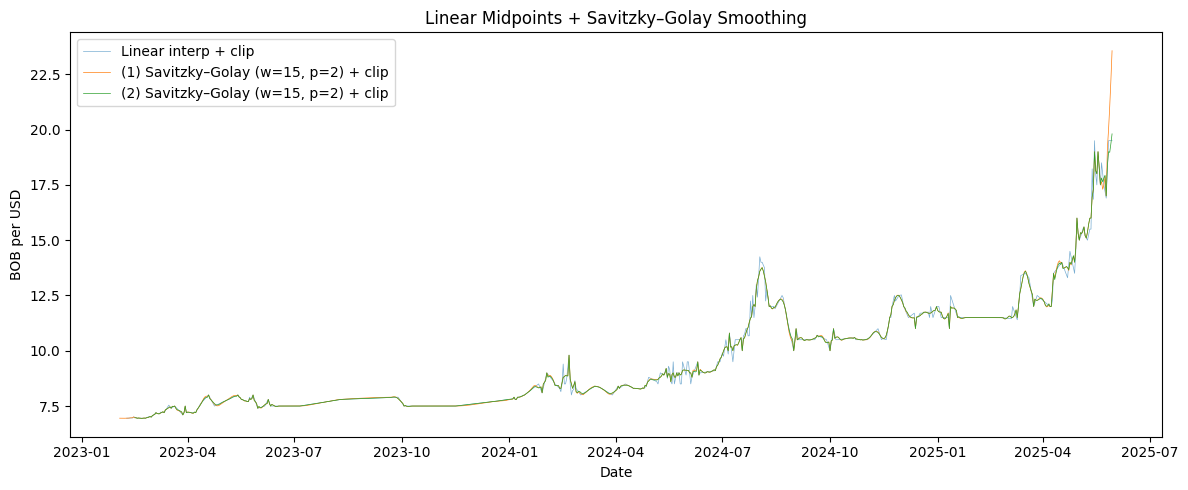

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(curve_clipped_lin, label='Linear interp + clip', linewidth=0.5, alpha=0.6)
ax.plot(curve_smoothC, label=f'(1) Savitzky–Golay (w={window_length}, p={polyorder}) + clip',
        linewidth=0.5)
ax.plot(curve_smooth_lin,
        label=f'(2) Savitzky–Golay (w={window_length}, p={polyorder}) + clip',
        linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('BOB per USD')
ax.set_title('Linear Midpoints + Savitzky–Golay Smoothing')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

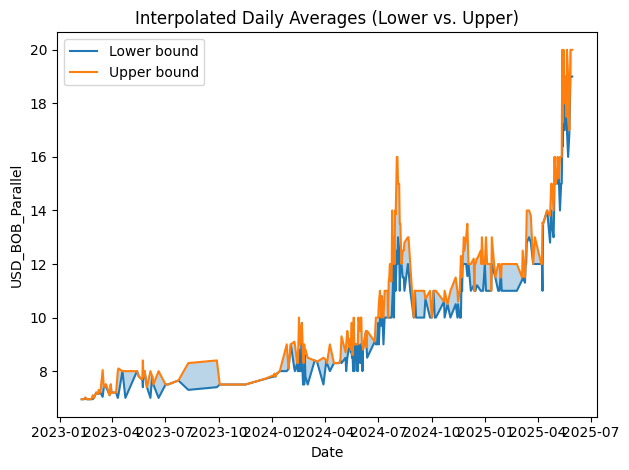

In [15]:
from utils.mongo_controller import mongo_controller

df = mongo_controller.query_data(_mode='all', collection='Daily_Averages')

df = df[['timestamp', 'USD_BOB_Parallel']]
df['USD_BOB_Parallel'] = df['USD_BOB_Parallel'].apply(
    lambda x: x['quote_interval'] if isinstance(x, dict) else [None, None])
df['lower_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[0])
df['upper_bound'] = df['USD_BOB_Parallel'].apply(lambda x: x[1])
df.drop(columns=['USD_BOB_Parallel'], inplace=True)
df = df[df['timestamp'] > '2023-02-01']  # filter to recent data

import pandas as pd
import matplotlib.pyplot as plt

# 1) Prepare your time index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# 2) Interpolate missing bounds
df['lower_i'] = df['lower_bound'].interpolate(method='linear')
df['upper_i'] = df['upper_bound'].interpolate(method='linear')

# 3) Plot
plt.figure()
plt.plot(df['timestamp'], df['lower_i'], label='Lower bound')
plt.plot(df['timestamp'], df['upper_i'], label='Upper bound')
plt.fill_between(df['timestamp'], df['lower_i'], df['upper_i'], alpha=0.3)
plt.xlabel('Date')
plt.ylabel('USD_BOB_Parallel')
plt.title('Interpolated Daily Averages (Lower vs. Upper)')
plt.legend()
plt.tight_layout()
plt.show()
